# Getting Started

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
# magic for autoreloading of modules
%reload_ext autoreload
%autoreload 2

# get to the parent dir of mai_dul repo
import os
os.chdir('../../')
os.getcwd()

'/Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24'

In [2]:
# install latest version deepul package
!pip install -e .

Obtaining file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24
  Preparing metadata (setup.py) ... done
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0
  DEPRECATION: Legacy editable install of deepul==0.1.0 from file:///Users/gokul/Study/Unsupervised-DL/Git/MAI_DUL_WS24 (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for deepul


In [3]:
from deepul.hw2_helper import *

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets ([SVHN](http://ufldl.stanford.edu/housenumbers/) and CIFAR10 (https://www.cs.toronto.edu/~kriz/cifar.html)).

Using downloaded and verified file: homeworks/hw2/data/train_32x32.mat


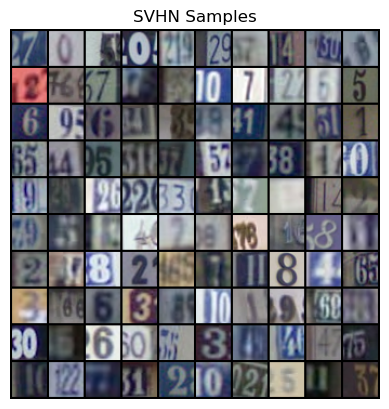

Files already downloaded and verified


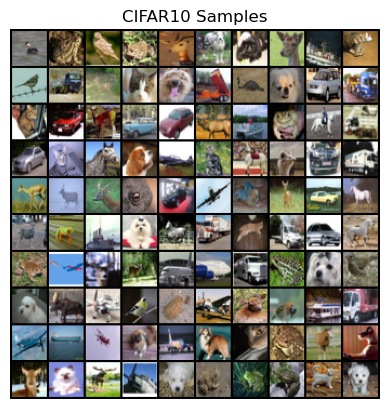

In [4]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
import numpy as np
import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from homeworks.hw2.vae import VAE_CNN


In [6]:
def compute_loss(recon_x, x, mu, log_var):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='none')
    recon_loss = recon_loss.sum(dim=(1, 2, 3))
    recon_loss = recon_loss.mean()
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1).mean()

    return recon_loss + kl_loss, recon_loss, kl_loss

In [7]:
def train_epoch(model, train_loader, optimizer, device):        
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, unit='batch')

    for batch_idx, (x, _) in enumerate(pbar):
        x = x.to(device)
        optimizer.zero_grad()
        
        recon_x, mu, log_var = model(x)
        loss, recon_loss, kl_loss = compute_loss(recon_x, x, mu, log_var)
        
        loss.backward()
        optimizer.step()

        train_losses.append([loss.item(), recon_loss.item(), kl_loss.item()])
        pbar.set_description(desc=f"batch_loss={loss.item():.4f}")
        
    return train_losses

In [8]:
def evaluate_model(model, dataloader, device):
    model.eval()
    test_elbo = 0
    test_recon = 0
    test_kl = 0

    with torch.no_grad():
        for x in dataloader:
            x = x[0].to(device)
            recon_x, mu, log_var = model(x)
            loss, recon_loss, kl_loss = compute_loss(recon_x, x, mu, log_var)
            test_elbo += loss.item()
            test_recon += recon_loss.item()
            test_kl += kl_loss.item()

    return (test_elbo/len(dataloader),
            test_recon/len(dataloader),
            test_kl/len(dataloader))

In [9]:
def generate_samples(model, device, latent_dim, test_loader):
    model.eval()
    with torch.no_grad():
        # 100 samples from prior
        z = torch.randn(100, latent_dim).to(device)
        samples = model.decode(z)
        samples = (samples.cpu().numpy() * 255).transpose(0, 2, 3, 1).astype(np.uint8)
        
        # 50 reconstruction pairs
        test_iter = iter(test_loader)
        x = next(test_iter)[0][:50].to(device)
        recon_x, _, _ = model(x)
        x = (x.cpu().numpy() * 255).transpose(0, 2, 3, 1).astype(np.uint8)
        recon_x = (recon_x.cpu().numpy() * 255).transpose(0, 2, 3, 1).astype(np.uint8)
        recon_pairs = np.concatenate([x, recon_x])
        
        # 10 interpolations
        x1 = next(test_iter)[0][:10].to(device)
        x2 = next(test_iter)[0][:10].to(device)
        z1, _ = model.encode(x1)
        z2, _ = model.encode(x2)
        
        interpolations = []
        for alpha in np.linspace(0, 1, 10):
            z = alpha * z1 + (1 - alpha) * z2
            interp = model.decode(z)
            interp = (interp.cpu().numpy() * 255).transpose(0, 2, 3, 1).astype(np.uint8)
            interpolations.append(interp)
        interpolations = np.concatenate(interpolations)

    return samples, recon_pairs, interpolations

In [10]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: torch dataset with (n_train, 3, 32, 32) color images as tensors with 256 values rescaled to [0, 1]
    test_data: torch dataset with (n_test, 3, 32, 32) color images as tensors with 256 values rescaled to [0, 1]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    torch.manual_seed(1)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() 
                         else "mps" if torch.backends.mps.is_available() 
                         else "cpu")

    print(f"Using device: {device}")

    # DataLoader settings based on device
    kwargs = {'num_workers': 8, 'pin_memory': False} if torch.cuda.is_available() else \
             {'num_workers': 0} if torch.backends.mps.is_available() else \
             {}

    # Hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    num_epochs = 20
    latent_dim = 16
    
    # Create data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=False)
    
    # Initialize model
    model = VAE_CNN(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training logging
    train_losses = []
    epoch_losses = []

    # Evaluate initial performance
    init_test_loss = evaluate_model(model, test_loader, device)
    epoch_losses.append(init_test_loss)
    
    # Training loop
    for epoch in range(num_epochs):
        train_metrics = train_epoch(model, train_loader, optimizer, device)
        train_losses.extend(train_metrics)

        test_metrics = evaluate_model(model, test_loader, device)
        epoch_losses.append(test_metrics)

        print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_metrics[0]:.4f}')
        
    
    # Generate samples
    samples, recon_pairs, interpolations = generate_samples(model, device, latent_dim, test_loader)
    
    return (np.array(train_losses),
            np.array(epoch_losses),
            samples,
            recon_pairs,
            interpolations)


### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Using downloaded and verified file: homeworks/hw2/data/train_32x32.mat
Using downloaded and verified file: homeworks/hw2/data/test_32x32.mat
Using device: mps


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 1/20, Test Loss: 41.3793


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 2/20, Test Loss: 38.5957


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 3/20, Test Loss: 38.1455


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 4/20, Test Loss: 37.4535


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 5/20, Test Loss: 37.6857


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 6/20, Test Loss: 37.0604


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 7/20, Test Loss: 37.5754


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 8/20, Test Loss: 36.9289


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 9/20, Test Loss: 36.7031


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 10/20, Test Loss: 36.8588


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 11/20, Test Loss: 36.5688


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 12/20, Test Loss: 36.4201


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 13/20, Test Loss: 36.9957


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 14/20, Test Loss: 36.3778


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 15/20, Test Loss: 37.0661


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 16/20, Test Loss: 36.3286


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 17/20, Test Loss: 36.3214


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 18/20, Test Loss: 36.1803


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 19/20, Test Loss: 36.2359


  0%|          | 0/573 [00:00<?, ?batch/s]

Epoch 20/20, Test Loss: 36.2819
Final -ELBO: 36.2819, Recon Loss: 24.2604, KL Loss: 12.0215


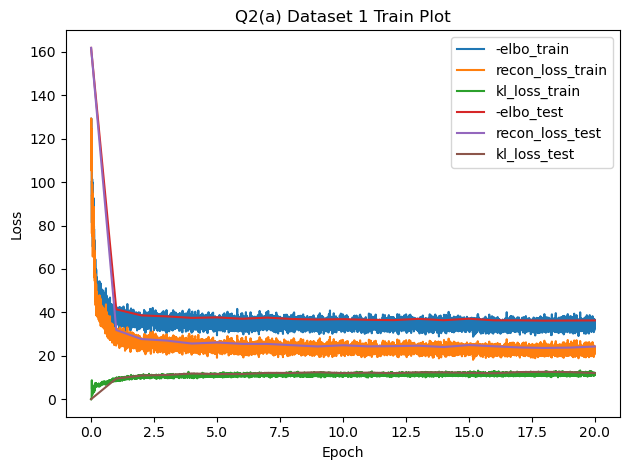

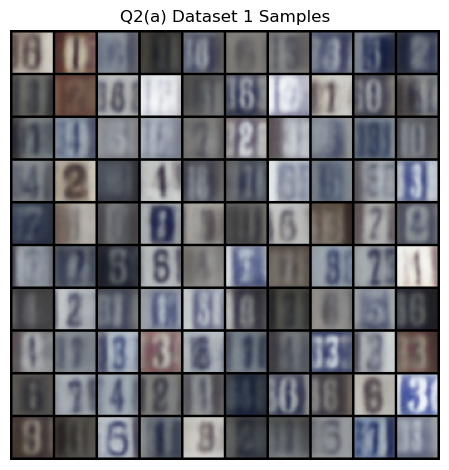

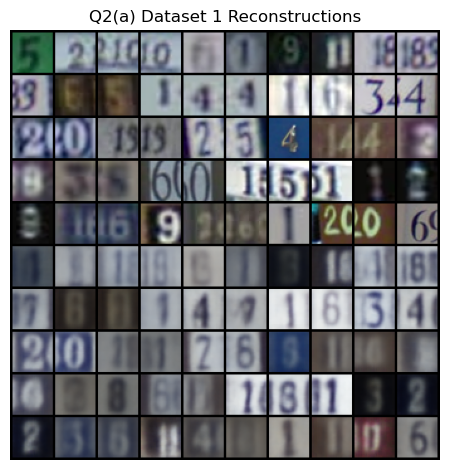

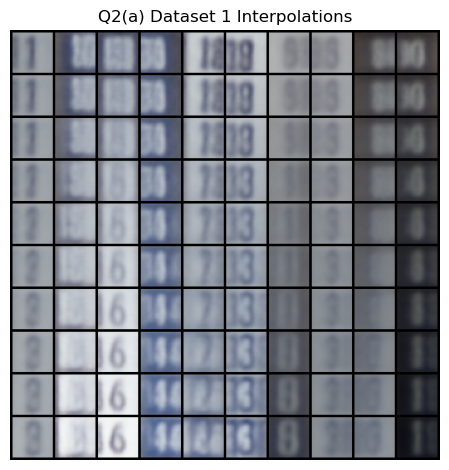

In [11]:
q2_save_results('a', 1, q2_a)

Files already downloaded and verified
Files already downloaded and verified
Using device: mps


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 1/20, Test Loss: 86.0359


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 2/20, Test Loss: 79.4673


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 3/20, Test Loss: 78.7698


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 4/20, Test Loss: 78.4244


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 5/20, Test Loss: 77.8958


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 6/20, Test Loss: 77.7709


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 7/20, Test Loss: 77.3301


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 8/20, Test Loss: 77.2428


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 9/20, Test Loss: 77.2896


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 10/20, Test Loss: 77.0481


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 11/20, Test Loss: 77.1170


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 12/20, Test Loss: 77.1484


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 13/20, Test Loss: 77.0048


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 14/20, Test Loss: 76.9391


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 15/20, Test Loss: 76.6720


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 16/20, Test Loss: 77.0835


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 17/20, Test Loss: 76.7855


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 18/20, Test Loss: 76.6882


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 19/20, Test Loss: 76.6262


  0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 20/20, Test Loss: 76.8190
Final -ELBO: 76.8190, Recon Loss: 58.9233, KL Loss: 17.8957


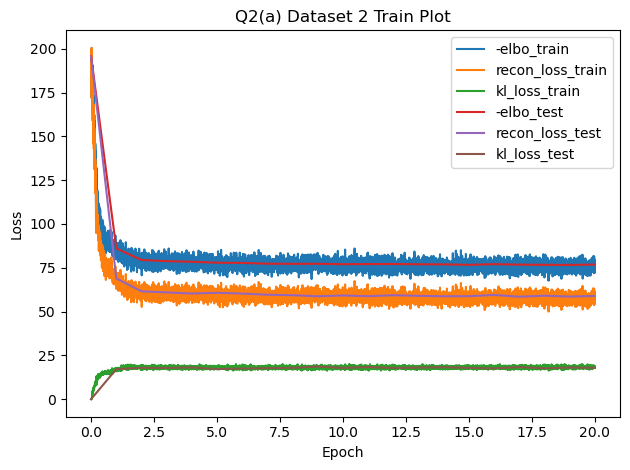

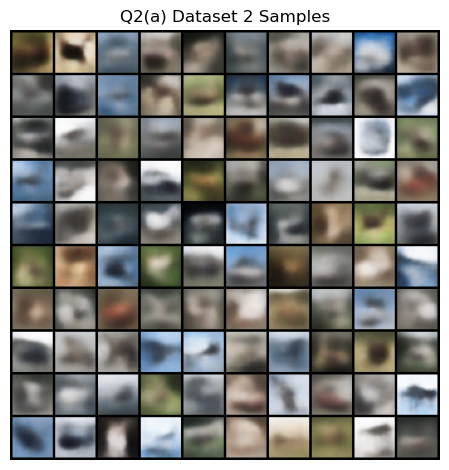

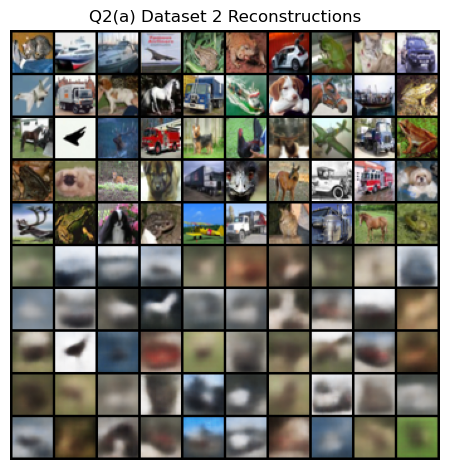

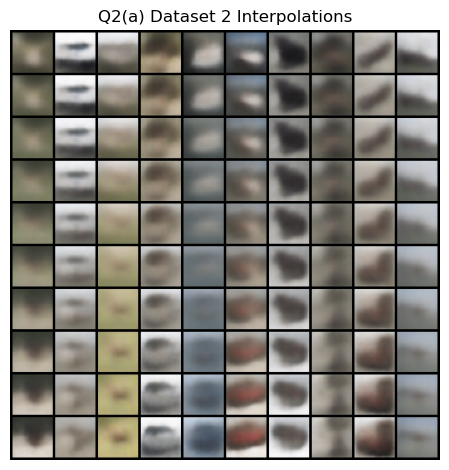

In [12]:
q2_save_results('a', 2, q2_a)